In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')




2024-03-16 01:49:23.002394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 01:49:23.002519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 01:49:23.135147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders

import splitfolders

input_folder = '/kaggle/input/slash-task-dataset/Data-slash'
output_folder = 'Data-split'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))


Copying files: 151 files [00:00, 220.29 files/s]


In [3]:
data_train_path = '/kaggle/working/Data-split/train'
# data_test_path = 'Fruits_Vegetables/test'
data_val_path = '/kaggle/working/Data-split/val'

In [4]:
img_width = 180
img_height =180 

In [5]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)

Found 120 files belonging to 2 classes.


In [6]:
data_cat = data_train.class_names

In [7]:
data_cat

['fashion', 'nutrition']

In [8]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                       image_size=(img_height,img_width),
                                                       batch_size=32,
                                                        shuffle=False,
                                                       validation_split=False)

Found 31 files belonging to 2 classes.


Found 31 images belonging to 2 classes.
Found 31 files belonging to 2 classes.


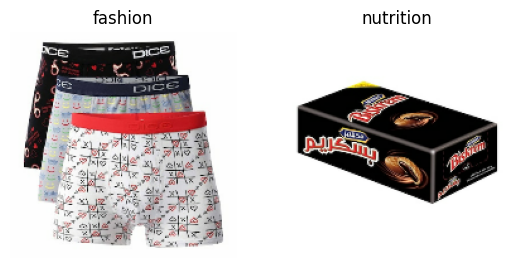

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(

)

# Generate augmented images
augmented_val_data = datagen.flow_from_directory(
    data_val_path,
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=True
)

# Convert augmented_train_data to TensorFlow dataset
augmented_data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)


plt.figure(figsize=(10, 10))
for batch in augmented_data_val.take(1):
    images, labels = batch
    for i in range(2):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
    break
plt.show()

Found 120 images belonging to 2 classes.
Found 120 files belonging to 2 classes.


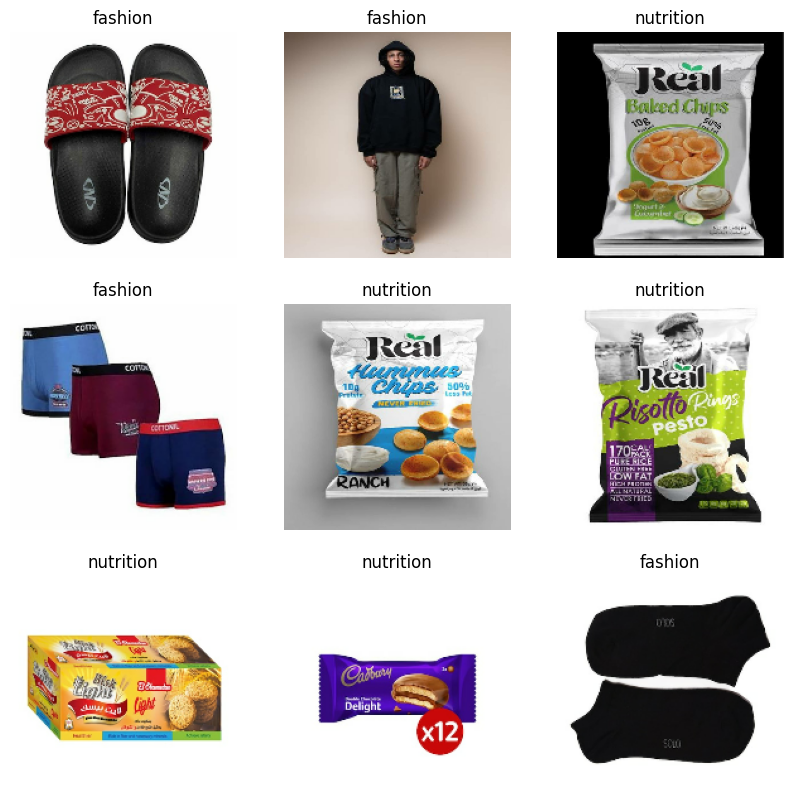

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2,  
    horizontal_flip=True,
    vertical_flip=True, 
    brightness_range=[0.5, 1.5] 
)

# Generate augmented images
augmented_train_data = datagen.flow_from_directory(
    data_train_path,
    target_size=(img_width, img_height),
    batch_size=32,
    shuffle=True
)

# Convert augmented_train_data to TensorFlow dataset
augmented_data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False)


# Plot some augmented images
plt.figure(figsize=(10, 10))
for batch in augmented_data_train.take(1):
    images, labels = batch
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
    break  
plt.show()

In [11]:
# Calculate the number of original images in the training dataset
num_batches = 0
for _ in data_train:
    num_batches += 1

batch_size = 32
num_original_images = num_batches * batch_size

# Calculate the number of additional images generated through augmentation
# The number of augmented images generated per original image is the same as the number of images in one batch of augmented_train_data
num_augmented_images_per_original = augmented_train_data.batch_size

# Add the counts together
overall_train_dataset_size = num_original_images + (num_augmented_images_per_original * num_original_images)

print("Overall training dataset size after augmentation:", overall_train_dataset_size)


Overall training dataset size after augmentation: 4224


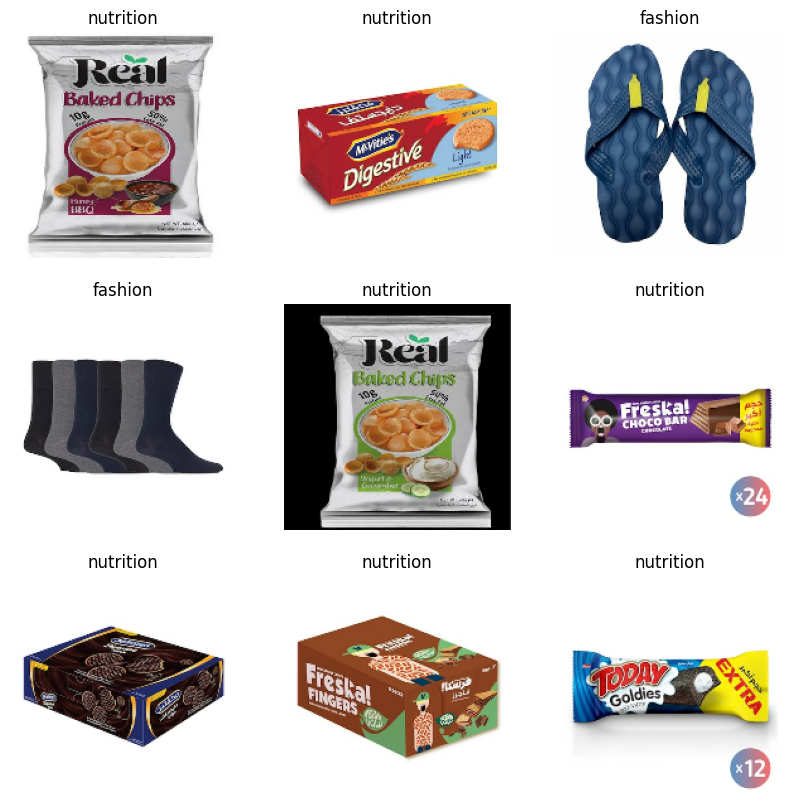

In [12]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

In [13]:
from tensorflow.keras.models import Sequential

In [14]:
data_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
augmented_train_data

In [16]:
from tensorflow.keras import layers, Sequential, regularizers

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.Dense(len(data_cat))
                  
])

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
epochs_size = 10
history = model.fit(augmented_data_train, validation_data=augmented_data_val, epochs=epochs_size)


Epoch 1/10


2024-03-16 01:49:57.795617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.65903, expected 1.97884
2024-03-16 01:49:57.795690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.48014, expected 2.79995
2024-03-16 01:49:57.795699: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.27252, expected 3.59232
2024-03-16 01:49:57.795707: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.49599, expected 3.8158
2024-03-16 01:49:57.795715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.91459, expected 3.2344
2024-03-16 01:49:57.795723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.81327, expected 4.13307
2024-03-16 01:49:57.795730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54455, expected 4.86435
2024-03-16 01:49:57.795738: E external/local_xla/xla/serv

1/4 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.3750 - loss: 0.7956

I0000 00:00:1710553801.808135      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-16 01:50:02.771767: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.25694, expected 1.9228
2024-03-16 01:50:02.771964: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32326: 2.24586, expected 1.91172
2024-03-16 01:50:02.771975: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32400: 3.0509, expected 2.36472
2024-03-16 01:50:02.771983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32401: 4.28383, expected 3.59765
2024-03-16 01:50:02.771996: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32402: 5.01082, expected 4.32464
2024-03-16 01:50:02.772006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32403: 5.49362, expected 4.80744
2024-03-16 01:50

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4471 - loss: 3.2568 

2024-03-16 01:50:12.469672: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.76215, expected 2.10118
2024-03-16 01:50:12.469747: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.3395, expected 3.67853
2024-03-16 01:50:12.469756: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.39455, expected 3.73359
2024-03-16 01:50:12.469764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.85817, expected 4.1972
2024-03-16 01:50:12.469772: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90077, expected 4.2398
2024-03-16 01:50:12.469779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.24221, expected 3.58124
2024-03-16 01:50:12.469787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.53579, expected 4.87482
2024-03-16 01:50:12.469794: E external/local_xla/xla/servi

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4560 - loss: 3.5515 - val_accuracy: 0.5161 - val_loss: 1.2963
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5483 - loss: 1.5016 - val_accuracy: 0.5484 - val_loss: 1.5907
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6854 - loss: 1.0349 - val_accuracy: 0.8065 - val_loss: 0.4600
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7733 - loss: 0.5754 - val_accuracy: 0.8387 - val_loss: 0.3008
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8210 - loss: 0.3849 - val_accuracy: 0.9032 - val_loss: 0.2307
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8871 - loss: 0.3201 - val_accuracy: 0.8065 - val_loss: 0.3846
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9158 - loss: 0.1950 - val_accuracy: 0.9032 - val_loss: 0.2539
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9223 - loss: 0.1955 - val_accuracy: 0.9355 - val_loss: 0.1567
Epoch 9/10
4

Text(0.5, 1.0, 'Accuracy')

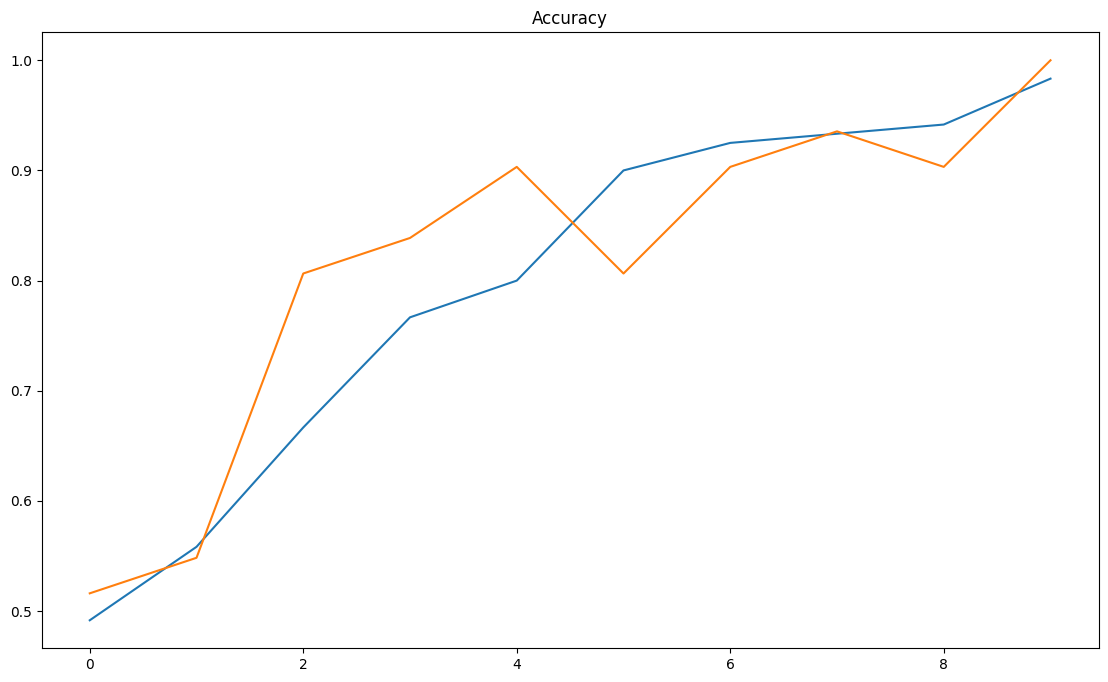

In [19]:
epochs_range = range(epochs_size)
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

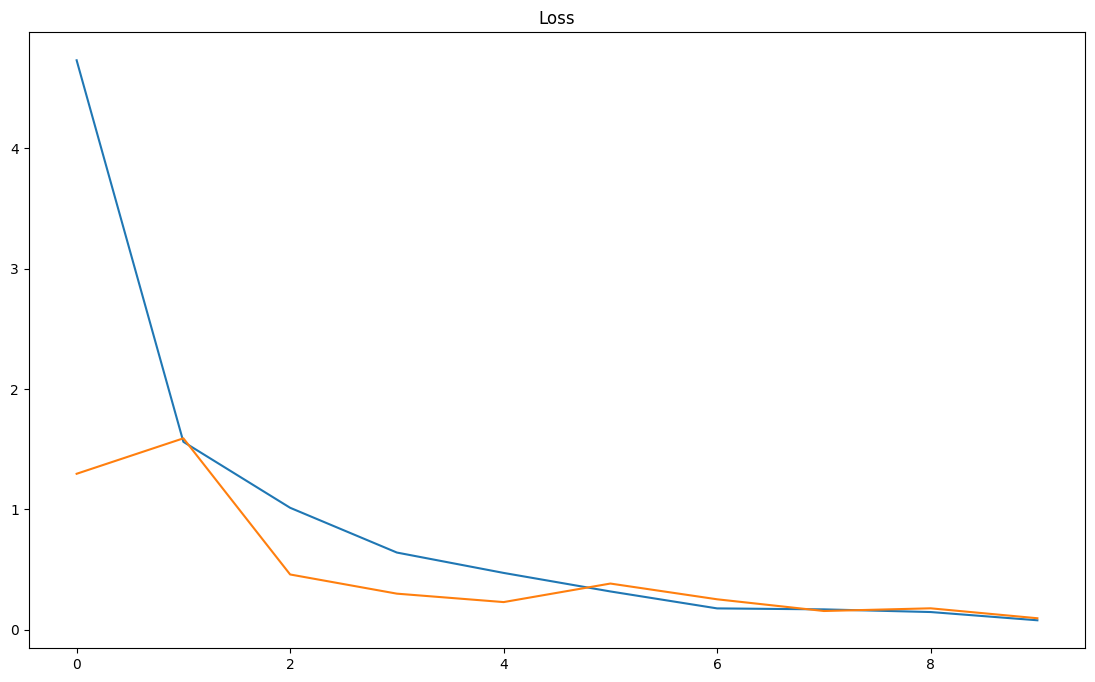

In [20]:
plt.figure(figsize=(30,8))
plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [21]:
image = '/kaggle/input/testtt/Screenshot_20240315_215026.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [22]:
predict = model.predict(img_bat)

2024-03-16 01:50:16.735138: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32400: 3.3443, expected 2.75812
2024-03-16 01:50:16.735209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32412: 4.7383, expected 4.15213
2024-03-16 01:50:16.735222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32413: 4.82692, expected 4.24074
2024-03-16 01:50:16.735236: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32487: 4.83261, expected 4.24643
2024-03-16 01:50:16.735254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32508: 4.54836, expected 3.96219
2024-03-16 01:50:16.735267: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32536: 4.76741, expected 4.18123
2024-03-16 01:50:16.735277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32545: 4.79533, expected 4.20916
2024-03-16 01:50:16.735288: E

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


In [23]:
score = tf.nn.softmax(predict)

In [24]:
print('image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

image is fashion with accuracy of 54.60


In [25]:
image = '/kaggle/input/testtt/Screenshot_20240315_215704.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [26]:
predict = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [27]:
score = tf.nn.softmax(predict)

In [28]:
print('image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

image is nutrition with accuracy of 99.91
